In [1]:
import numpy as np
from scipy import stats
from datasets import load_dataset

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from seq2seq.mt.transformer_sys import LitTokenizer

**Set constants**

In [2]:
DATASET_PATH = f"../../.data/miguel"
SRC_LANG, TRG_LANG = ("en", "es")

SRC_VOCAB_SIZE=16000  # I like multiples of 2 (8k, 16k, 32k...)
TRG_VOCAB_SIZE=16000
SRC_MIN_FREQUENCY=3   # 2 minimum
TRG_MIN_FREQUENCY=3

## Define Tokenizer

In [3]:
# Define Tokenizer
# Do not use padding here. Datasets are preprocessed before batching
tokenizer = LitTokenizer(padding=False, truncation=False)

In [4]:
print(f"SRC default tokens: {tokenizer.src_tokenizer.get_vocab()}")
print(f"TRG default tokens: {tokenizer.trg_tokenizer.get_vocab()}")

SRC default tokens: {'[UNK]': 3, '[SOS]': 0, '[MASK]': 4, '[PAD]': 2, '[EOS]': 1}
TRG default tokens: {'[PAD]': 2, '[UNK]': 3, '[EOS]': 1, '[SOS]': 0, '[MASK]': 4}


### Train/Load/Save Tokenizer

**Train vocabulary:**

In [5]:
# Train tokenizer
vocab_file = "train"
src_files = [f"{DATASET_PATH}/preprocessed/{vocab_file}_{SRC_LANG}.csv"]
trg_files = [f"{DATASET_PATH}/preprocessed/{vocab_file}_{TRG_LANG}.csv"]
tokenizer.train_vocabs(src_files, trg_files,
                       src_vocab_size=SRC_VOCAB_SIZE, trg_vocab_size=TRG_VOCAB_SIZE,
                       src_min_frequency=SRC_MIN_FREQUENCY, trg_min_frequency=TRG_MIN_FREQUENCY)
print("Training done!")

Training done!


**Load vocabulary:**

In [6]:
# # Load vocab
# src_vocab_file = f"{DATASET_PATH}/vocab/{SRC_LANG}-vocab.txt"
# trg_vocab_file = f"{DATASET_PATH}/vocab/{TRG_LANG}-vocab.txt"
# tokenizer.load_vocabs(src_vocab_file, trg_vocab_file)

**Save vocabulary:**

In [7]:
# Save vocabs
folder = f"./"
tokenizer.save_vocabs(folder, src_name=SRC_LANG, trg_name=TRG_LANG)
print("Vocabs saved!")

Vocabs saved!


Check if the tokenizer is working as expected

In [8]:
text = "Transfomers are awesome! 😄"
print(f"ORIGINAL: {text}")

enc = tokenizer.src_tokenizer.encode(text)
print(f"ENCODED (ids): {enc.ids}")
print(f"ENCODED (tokens): {enc.tokens}")

dec = tokenizer.src_tokenizer.decode(enc.ids)
print(f"DECODED: {dec}")


ORIGINAL: Transfomers are awesome! 😄
ENCODED (ids): [0, 15837, 496, 11325, 346, 1163, 285, 496, 5, 3, 1]
ENCODED (tokens): ['[SOS]', 'transf', '##ome', '##rs', 'are', 'aw', '##es', '##ome', '!', '[UNK]', '[EOS]']
DECODED: transfomers are awesome!


## Load Dataset


In [9]:
# Get dataset (train/val)
dataset = load_dataset('csv', data_files={'train': [f"{DATASET_PATH}/preprocessed/train.csv"],
                                          'validation': [f"{DATASET_PATH}/preprocessed/dev.csv"],
                                          'test': [f"{DATASET_PATH}/preprocessed/test.csv"],
                                          })

Using custom data configuration default
Reusing dataset csv (/home/scarrion/.cache/huggingface/datasets/csv/default-167d0dd0310cacdc/0.0.0/49187751790fa4d820300fd4d0707896e5b941f1a9c644652645b866716a4ac4)


### Encode dataset words

In [10]:
# Tokenize
def encode(examples):
    # Encode strings
    _src_tokenized = tokenizer.src_tokenizer.encode_batch(examples[SRC_LANG])
    _trg_tokenized = tokenizer.trg_tokenizer.encode_batch(examples[TRG_LANG])

    # Select features
    src_tokenized = [{'ids': x.ids, 'tokens': x.tokens} for x in _src_tokenized]
    trg_tokenized = [{'ids': x.ids, 'tokens': x.tokens} for x in _trg_tokenized]

    new_examples = {'src': src_tokenized, 'trg': trg_tokenized}
    return new_examples

In [11]:
test_dataset = dataset['test'].map(encode, batched=True)
val_dataset = dataset['validation'].map(encode, batched=True)
train_dataset = dataset['train'].map(encode, batched=True)  # Train last to check for "unk_token" problem


Print the number of pairs for each partition: train, dev and test.

In [12]:
print("Total pairs:")
print(f"\t- Train: {len(train_dataset)}")
print(f"\t- Dev: {len(val_dataset)}")
print(f"\t- Test: {len(test_dataset)}")

Total pairs:
	- Train: 1960641
	- Dev: 3003
	- Test: 3000


### Filter dataset entries

In [13]:
#SRC_MIN_LENGTH = 1
#TRG_MIN_LENGTH = 1
#SRC_MAX_LENGTH = 150
#TRG_MAX_LENGTH = 150

#train_dataset = train_dataset.filter(lambda example: SRC_MIN_LENGTH <= len(example['src']['ids']) <= SRC_MAX_LENGTH and TRG_MIN_LENGTH <= len(example['trg']['ids']) <= TRG_MAX_LENGTH)
#val_dataset = val_dataset.filter(lambda example: SRC_MIN_LENGTH <= len(example['src']['ids']) <= SRC_MAX_LENGTH and TRG_MIN_LENGTH <= len(example['trg']['ids']) <= TRG_MAX_LENGTH)
#test_dataset = test_dataset.filter(lambda example: SRC_MIN_LENGTH <= len(example['src']['ids']) <= SRC_MAX_LENGTH and TRG_MIN_LENGTH <= len(example['trg']['ids']) <= TRG_MAX_LENGTH)

Print the number of pairs for each partition: train, dev and test.

In [14]:
#print("Total pairs:")
#print(f"\t- Train: {len(train_dataset)}")
#print(f"\t- Dev: {len(val_dataset)}")
#print(f"\t- Test: {len(test_dataset)}")

## Dataset exploration

### Viewing tokens

Now, we can the print the tokenized pairs to see what are we really doing. I usually like to print the first and last
`n` pairs (and a few random ones).

In [15]:
def view_pairs(pairs, indices):
    for i, idx in enumerate(indices):
        src = pairs[i]['src']['tokens']
        trg = pairs[i]['trg']['tokens']
        print(f"#{i+1}: " + "-"*20)
        print(f"src => {src}")
        print(f"trg => {trg}")
    print("")

In [16]:
n=2
print("Head: " + "#"*20)
print("(Firsts) Train dataset: " + "*"*20)
view_pairs(train_dataset, indices=range(0, n))

print("(Firsts) Dev dataset: " + "*"*20)
view_pairs(val_dataset, indices=range(0, n))

print("(Firsts) Test dataset: " + "*"*20)
view_pairs(test_dataset, indices=range(0, n))

print("Tail: " + "#"*20)
print("(Lasts) Train dataset: " + "*"*20)
view_pairs(train_dataset, indices=range(-1,-n-1,-1))

print("(Lasts) Dev dataset: " + "*"*20)
view_pairs(val_dataset, indices=range(-1,-n-1,-1))

print("(Lasts) Test dataset: " + "*"*20)
view_pairs(test_dataset, indices=range(-1,-n-1,-1))


Head: ####################
(Firsts) Train dataset: ********************
#1: --------------------
src => ['[SOS]', 'resumption', 'of', 'the', 'session', '[EOS]']
trg => ['[SOS]', 'reanudación', 'del', 'período', 'de', 'sesiones', '[EOS]']
#2: --------------------
src => ['[SOS]', 'i', 'declare', 'resumed', 'the', 'session', 'of', 'the', 'european', 'parliament', 'adjourned', 'on', 'friday', '17', 'december', '1999', ',', 'and', 'i', 'would', 'like', 'once', 'again', 'to', 'wish', 'you', 'a', 'happy', 'new', 'year', 'in', 'the', 'hope', 'that', 'you', 'enjoyed', 'a', 'pleasant', 'fest', '##ive', 'period', '.', '[EOS]']
trg => ['[SOS]', 'declaro', 'reanudado', 'el', 'período', 'de', 'sesiones', 'del', 'parlamento', 'europeo', ',', 'interrumpido', 'el', 'viernes', '17', 'de', 'diciembre', 'pasado', ',', 'y', 'reitero', 'a', 'sus', 'señorías', 'mi', 'deseo', 'de', 'que', 'hayan', 'tenido', 'unas', 'buenas', 'vacaciones', '.', '[EOS]']

(Firsts) Dev dataset: ********************
#1: ---

### Sequence lengths

Since some of models that use of attention have a quadratic growth with regard the length of a sequence, we need to 
carefully study the lengths of the pairs in our dataset so that we can choose the maximum length of a sequence in a 
educated way.

From the results below we observe a huge gap between pairs. This gap gets accentuated for the train and dev/test partitions. In the former, the gap is greater than in the later.

In [17]:
# Get lengths (too slow)
train_lenghts = np.array([(len(src['ids']), len(trg['ids'])) for (src, trg) in zip(train_dataset['src'], train_dataset['trg'])])
dev_lenghts = np.array([(len(src['ids']), len(trg['ids'])) for (src, trg) in zip(val_dataset['src'], val_dataset['trg'])])
test_lenghts = np.array([(len(src['ids']), len(trg['ids'])) for (src, trg) in zip(test_dataset['src'], test_dataset['trg'])])

# Get min lengths
train_min_len = train_lenghts.min(axis=0).astype(int)
dev_min_len = dev_lenghts.min(axis=0).astype(int)
test_min_len = test_lenghts.min(axis=0).astype(int)

# Get max lengths
train_max_len = train_lenghts.max(axis=0).astype(int)
dev_max_len = dev_lenghts.max(axis=0).astype(int)
test_max_len = test_lenghts.max(axis=0).astype(int)

In [18]:
print(f"Train => Range length: src={train_min_len[0]}-{train_max_len[0]} | trg={train_min_len[1]}-{train_max_len[1]}")
print(f"Dev => Range length: src={dev_min_len[0]}-{dev_max_len[0]} | trg={dev_min_len[1]}-{dev_max_len[1]}")
print(f"Test => Range length: src={test_min_len[0]}-{test_max_len[0]} | trg={test_min_len[1]}-{test_max_len[1]}")

Train => Range length: src=3-1121 | trg=3-1069
Dev => Range length: src=3-186 | trg=3-205
Test => Range length: src=3-127 | trg=3-150


We can also get some statistical values from partitions to get a rough idea of how long is the average sequence or in which range of values we can find 95% of our data.

By doing this, we are obtaining a value with which perform the sequence cut in the dataset.

In [19]:
# Get means
train_mean_len = train_lenghts.mean(axis=0).round().astype(int)
dev_mean_len = dev_lenghts.mean(axis=0).round().astype(int)
test_mean_len = test_lenghts.mean(axis=0).round().astype(int)

print(f"Train => Mean length: src={train_mean_len[0]} | trg={train_mean_len[1]}")
print(f"Dev => Mean length: src={dev_mean_len[0]} | trg={dev_mean_len[1]}")
print(f"Test => Mean length: src={test_mean_len[0]} | trg={test_mean_len[1]}")


Train => Mean length: src=31 | trg=33
Dev => Mean length: src=30 | trg=33
Test => Mean length: src=27 | trg=30


#### Checking for zero-length sequences

Additionally, I like to check if there is any sequence with length zero. This is more important that it looks, since an empty sequence could indicate an error or problem in the dataset which could lead to a waste of computational resources, a `RuntimeError` in the middle of the training or even jeopardising the training of our model

In [20]:
tr_no_sent = np.sum(train_lenghts == 0, axis=0).astype(int)
dev_no_sent = np.sum(dev_lenghts == 0, axis=0).astype(int)
ts_no_sent = np.sum(test_lenghts == 0, axis=0).astype(int)

print(f"Train => Sentences with no words: SRC={tr_no_sent[0]} | TRG={tr_no_sent[1]}")
print(f"Dev => Sentences with no words: SRC={dev_no_sent[0]} | TRG={dev_no_sent[1]}")
print(f"Test => Sentences with no words: SRC={ts_no_sent[0]} | TRG={ts_no_sent[1]}")

Train => Sentences with no words: SRC=0 | TRG=0
Dev => Sentences with no words: SRC=0 | TRG=0
Test => Sentences with no words: SRC=0 | TRG=0


### Viewing extreme sequences

To know the range in which the sequences are ranging is important, but it is even more important to understand what are the extreme pairs in that range. By studying these extreme cases, we can educatively tune our model to get the most of our dataset without compromissing their requirements too much.

To get these extreme pairs, we simply keep the indices of the sorted lengths using `argsort`.

In [21]:
# Sort columns independently (ascending)
train_sort_len_idx = np.argsort(train_lenghts, axis=0)
dev_sort_len_idx = np.argsort(dev_lenghts, axis=0)
test_sort_len_idx = np.argsort(test_lenghts, axis=0)

Now we see which sentences contain the minimum and the maximum number of tokens. The shortests sequences correspond to word-to-word translations such as: `italy => italia` or `Informality => Informalidad`.

**Notice** that columns in the array are sorted independely. This is because a source sequence can be a single word but its translation can be many (and viceversa), such as: `shopping => ir de compras`

In [22]:
def view_lengths(raw, indices):
    for i, idx in enumerate(indices):
        src_idx = int(idx[0])
        trg_idx = int(idx[1])

        p1_src, p1_trg = raw[src_idx]['src']['tokens'], raw[src_idx]['trg']['tokens']  # Shortest src (+trg)
        p2_src, p2_trg = raw[trg_idx]['src']['tokens'], raw[trg_idx]['trg']['tokens']  # Shortest trg (+src)

        print(f"#{i+1}: " + "-"*20)
        print(f"[Shortest SRC: idx={idx[0]}]")
        print(f"\t- src (len={len(p1_src)}): {p1_src} => {p1_trg}")

        print(f"[Shortest TRG: idx={idx[1]}]")
        print(f"\t- trg (len={len(p2_src)}): {p2_src} => {p2_trg}")
    print("")

In [23]:
n=1
print("Shortest: " + "#"*20)
print("(Shortest) Train dataset: " + "*"*20)
view_lengths(train_dataset, indices=train_sort_len_idx[:n])

print("(Shortest) Dev dataset: " + "*"*20)
view_lengths(val_dataset, indices=dev_sort_len_idx[:n])

print("(Shortest) Test dataset: " + "*"*20)
view_lengths(test_dataset, indices=test_sort_len_idx[:n])

n=1
print("Longest: " + "#"*20)
print("(Longest) Train dataset: " + "*"*20)
view_lengths(train_dataset, indices=train_sort_len_idx[::-1][:n])

print("(Longest) Dev dataset: " + "*"*20)
view_lengths(val_dataset, indices=dev_sort_len_idx[::-1][:n])

print("(Longest) Test dataset: " + "*"*20)
view_lengths(test_dataset, indices=test_sort_len_idx[::-1][:n])



Shortest: ####################
(Shortest) Train dataset: ********************
#1: --------------------
[Shortest SRC: idx=638894]
	- src (len=3): ['[SOS]', '.', '[EOS]'] => ['[SOS]', '.', '[EOS]']
[Shortest TRG: idx=527915]
	- trg (len=3): ['[SOS]', '.', '[EOS]'] => ['[SOS]', '.', '[EOS]']

(Shortest) Dev dataset: ********************
#1: --------------------
[Shortest SRC: idx=2621]
	- src (len=3): ['[SOS]', 'austria', '[EOS]'] => ['[SOS]', 'austria', '[EOS]']
[Shortest TRG: idx=2621]
	- trg (len=3): ['[SOS]', 'austria', '[EOS]'] => ['[SOS]', 'austria', '[EOS]']

(Shortest) Test dataset: ********************
#1: --------------------
[Shortest SRC: idx=135]
	- src (len=3): ['[SOS]', 'repercussions', '[EOS]'] => ['[SOS]', 'repercusiones', '[EOS]']
[Shortest TRG: idx=2697]
	- trg (len=3): ['[SOS]', 'monitoring', '[EOS]'] => ['[SOS]', 'vigilancia', '[EOS]']

Longest: ####################
(Longest) Train dataset: ********************
#1: --------------------
[Shortest SRC: idx=1726867]
	- 

### Plotting length distribution

After printing a few examples of pairs, it is interesting to plot the length distribution of the different partitions so we can get an intuition on where to set the length cut.

From the plots below, we see that the train partition come from a different source than our dev and test partitions. Luckily, this won't be a problem for setting out cut since the training partition is way bigger than our dev/test partitions

In [24]:
# Get lengths
tr_src_len = train_lenghts[:, 0]
tr_trg_len = train_lenghts[:, 1]
dev_src_len = dev_lenghts[:, 0]
dev_trg_len = dev_lenghts[:, 1]
ts_src_len = test_lenghts[:, 0]
ts_trg_len = test_lenghts[:, 1]

# Pair data and labels
h_data = [tr_src_len, tr_trg_len, dev_src_len, dev_trg_len, ts_src_len, ts_trg_len]
h_labels = ['tr_src_len', 'tr_trg_len', 'dev_src_len', 'dev_trg_len', 'ts_src_len', 'ts_trg_len']

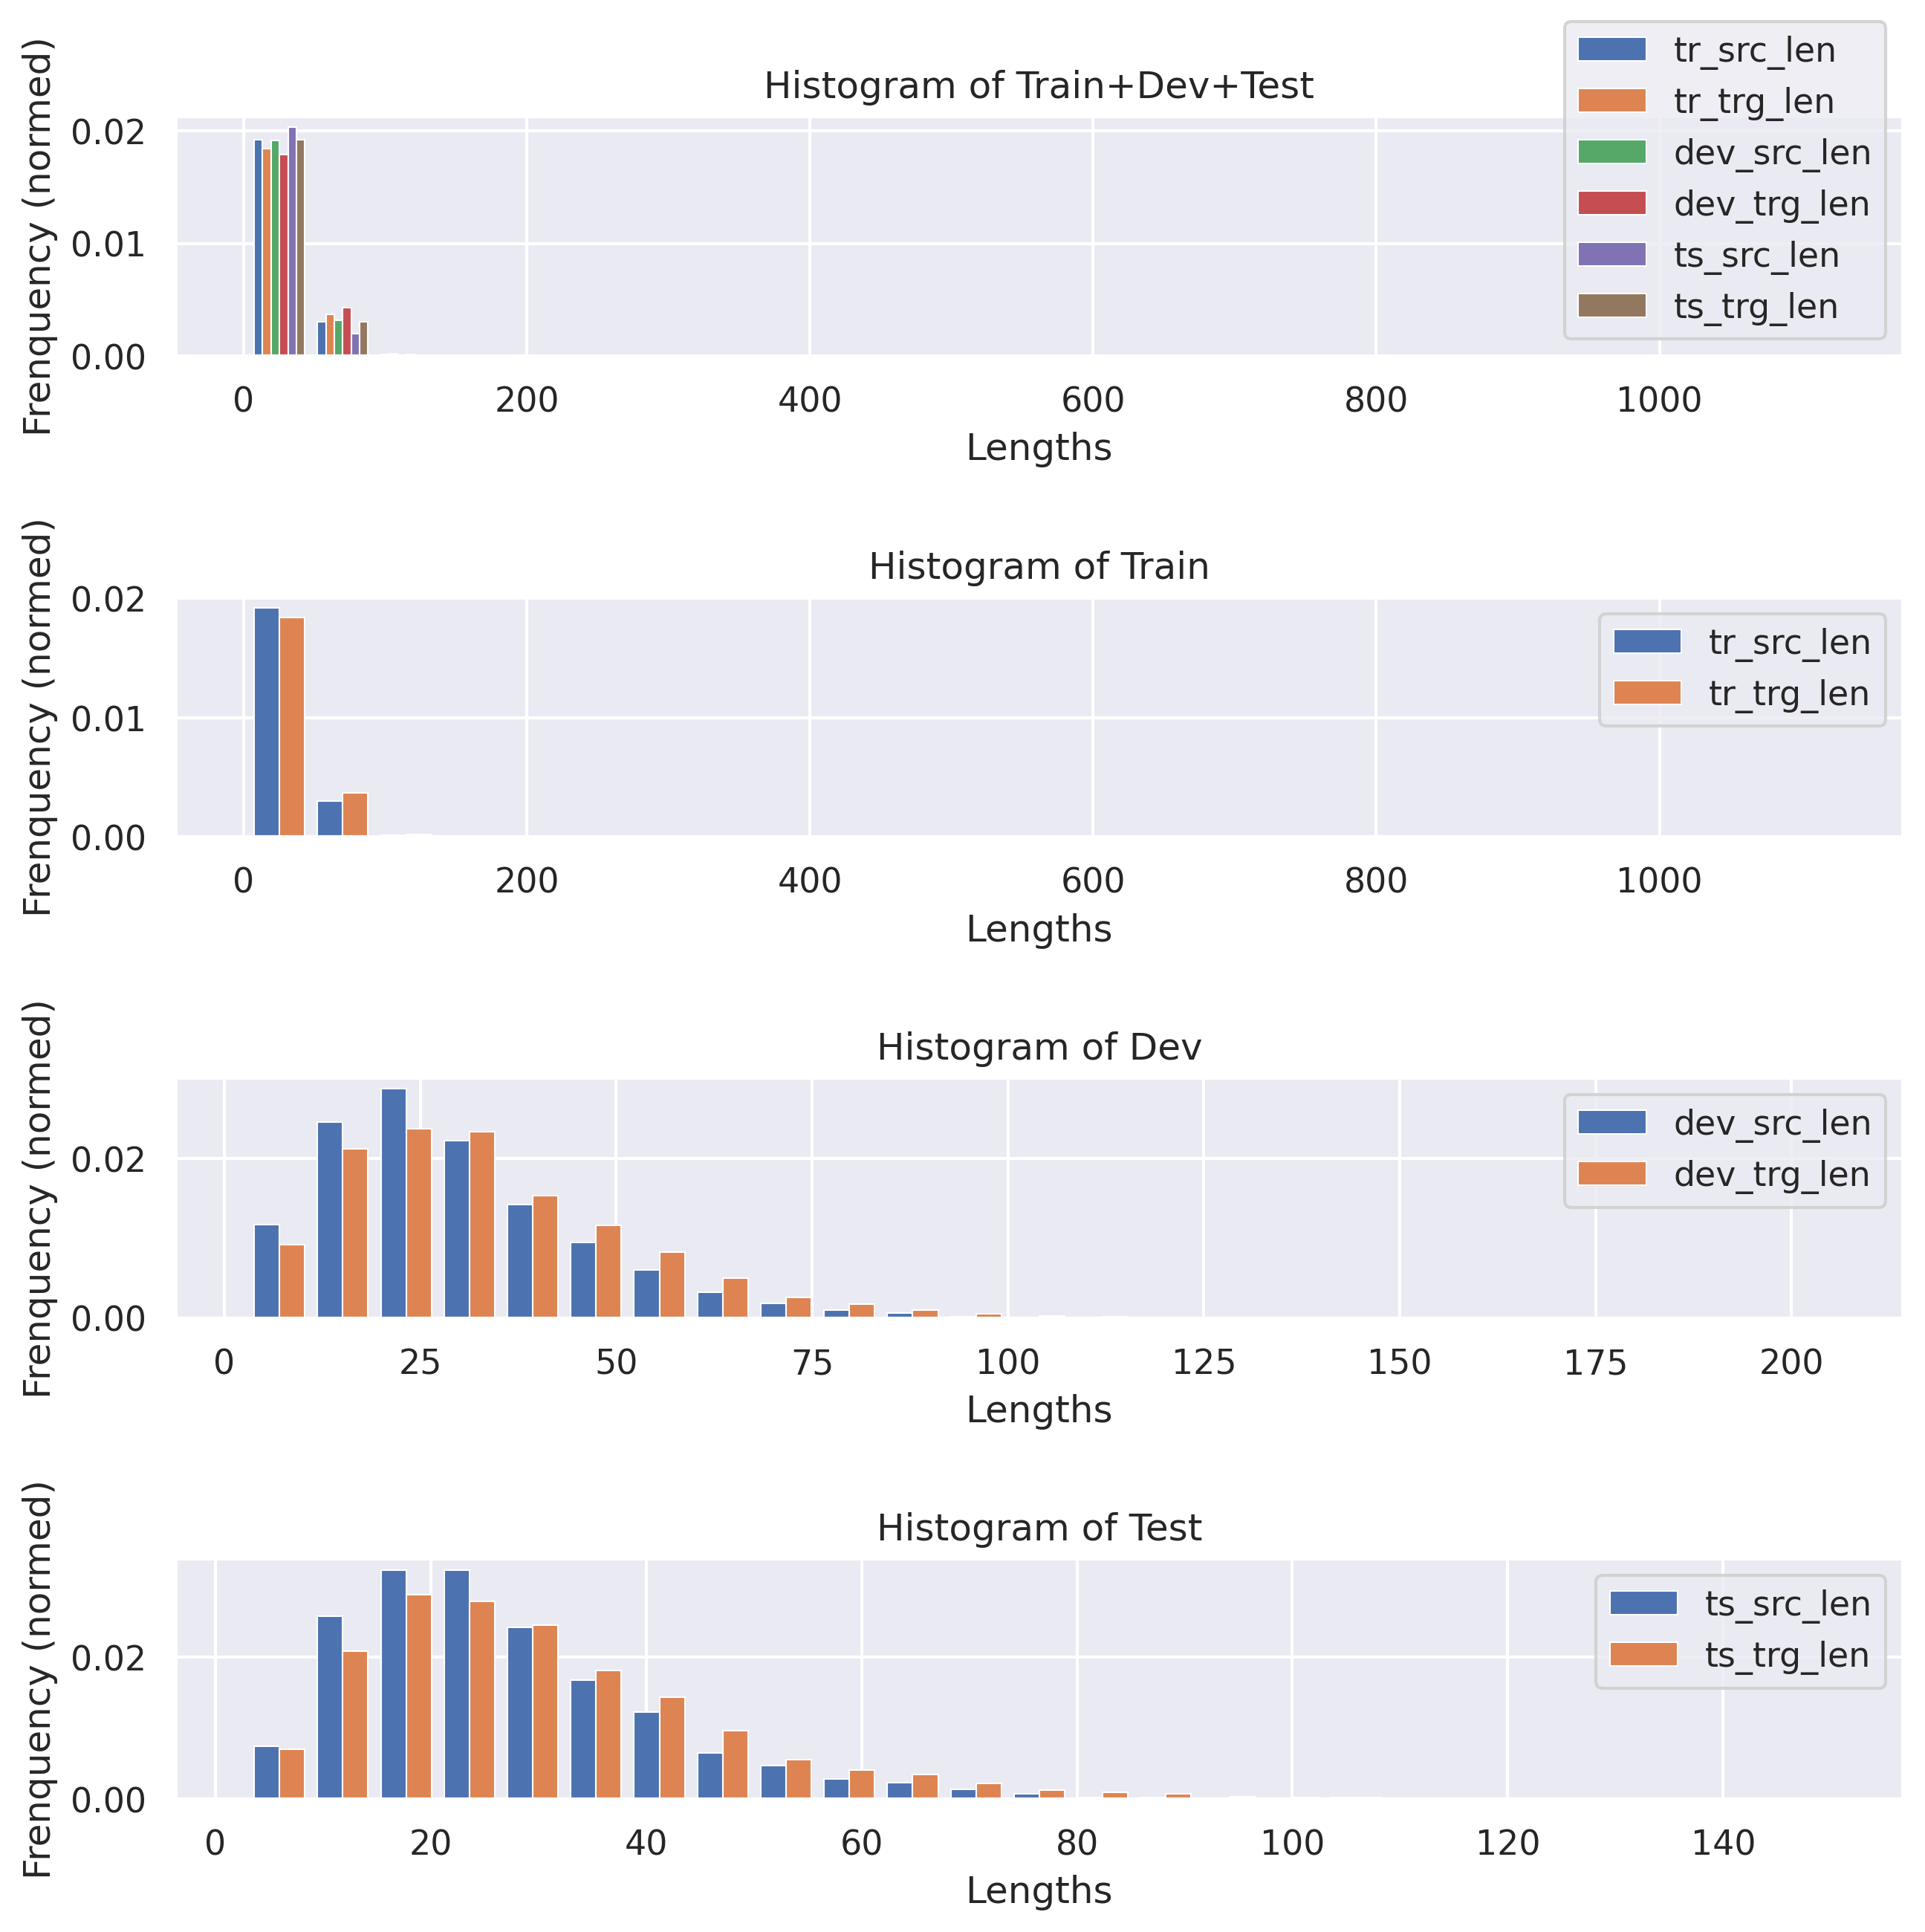

In [25]:
def get_hist(ax, data, labels, title, bins=25):
    # Draw the plot
    ax.hist(data, bins=bins, density=True, label=labels, linewidth=0.5)

    # Title and labels
    ax.set_title(title)
    ax.set_xlabel("Lengths")
    ax.set_ylabel("Frenquency (normed)")
    ax.legend()


plt.rcParams['figure.figsize'] = [10, 10]  # Fix size
plt.rcParams['figure.dpi'] = 300  # Fix white bars (+linewidth=0.5)

fig, axs = plt.subplots(4)
get_hist(axs[0], h_data, h_labels, f"Histogram of Train+Dev+Test")
get_hist(axs[1], h_data[0:2], h_labels[0:2], f"Histogram of Train")
get_hist(axs[2], h_data[2:4], h_labels[2:4], f"Histogram of Dev")
get_hist(axs[3], h_data[4:6], h_labels[4:6], f"Histogram of Test")

plt.rcParams['figure.figsize'] = [10, 10]
plt.subplots_adjust(hspace=1.0)


### Setting the length threshold

Let's say that our model has only memory for sequences with a maximum of 150 tokens. With this value in mind (and the sequence length distribution), we can now exactly know how much data we are leaving behind.

This is important so that we can get the most of our model by carefully tuning it with the statistical values that we have calculated. Additionally, since this is an educated process, we will also have a rough idea of how much our model could improve if we increase the computational resources.


In [26]:
MAX_SEQ_LENGTH = 150
tr_src_p_score = stats.percentileofscore(train_lenghts[:, 0], MAX_SEQ_LENGTH)
tr_trg_p_score = stats.percentileofscore(train_lenghts[:, 1], MAX_SEQ_LENGTH)
print("Train: percentile of length {}: src={:.2f} | trg={:.2f}".format(MAX_SEQ_LENGTH, tr_src_p_score, tr_trg_p_score))

dev_src_p_score = stats.percentileofscore(dev_lenghts[:, 0], MAX_SEQ_LENGTH)
dev_trg_p_score = stats.percentileofscore(dev_lenghts[:, 1], MAX_SEQ_LENGTH)
print("Dev: percentile of length {}: src={:.2f} | trg={:.2f}".format(MAX_SEQ_LENGTH, dev_src_p_score, dev_trg_p_score))

ts_src_p_score = stats.percentileofscore(test_lenghts[:, 0], MAX_SEQ_LENGTH)
ts_trg_p_score = stats.percentileofscore(test_lenghts[:, 1], MAX_SEQ_LENGTH)
print("Test: percentile of length {}: src={:.2f} | trg={:.2f}".format(MAX_SEQ_LENGTH, ts_src_p_score, ts_trg_p_score))


Train: percentile of length 150: src=99.96 | trg=99.93
Dev: percentile of length 150: src=99.97 | trg=99.93
Test: percentile of length 150: src=100.00 | trg=100.00


In [27]:
def get_percentiles(src_trg_lengths, lower_q, upper_q):
    p = np.percentile(src_trg_lengths,  [lower_q, upper_q], axis=0)
    (lb_tr_src_len, lb_tr_trg_len), (ub_tr_src_len, ub_tr_trg_len) = p

    print(f"- SRC ({lower_q}-{upper_q}%): {int(lb_tr_src_len)}-{int(ub_tr_src_len)}")
    print(f"- TRG ({lower_q}-{upper_q}%): {int(lb_tr_trg_len)}-{int(ub_tr_trg_len)}")

    return p

In [28]:
lower_q, upper_q = (0, 99.95)  # Percentage
print("Percentile Train:")
tr_p = get_percentiles(train_lenghts, *(lower_q, upper_q))
print("Percentile Dev:")
dev_p = get_percentiles(dev_lenghts, *(lower_q, upper_q))
print("Percentile Test:")
ts_p = get_percentiles(test_lenghts, *(lower_q, upper_q))


Percentile Train:
- SRC (0-99.95%): 3-145
- TRG (0-99.95%): 3-163
Percentile Dev:
- SRC (0-99.95%): 3-124
- TRG (0-99.95%): 3-139
Percentile Test:
- SRC (0-99.95%): 3-112
- TRG (0-99.95%): 3-142
